## Setup

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Get the data

In [2]:
import pandas as pd
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
# Download data in 'datasets' directory
#fetch_housing_data()

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


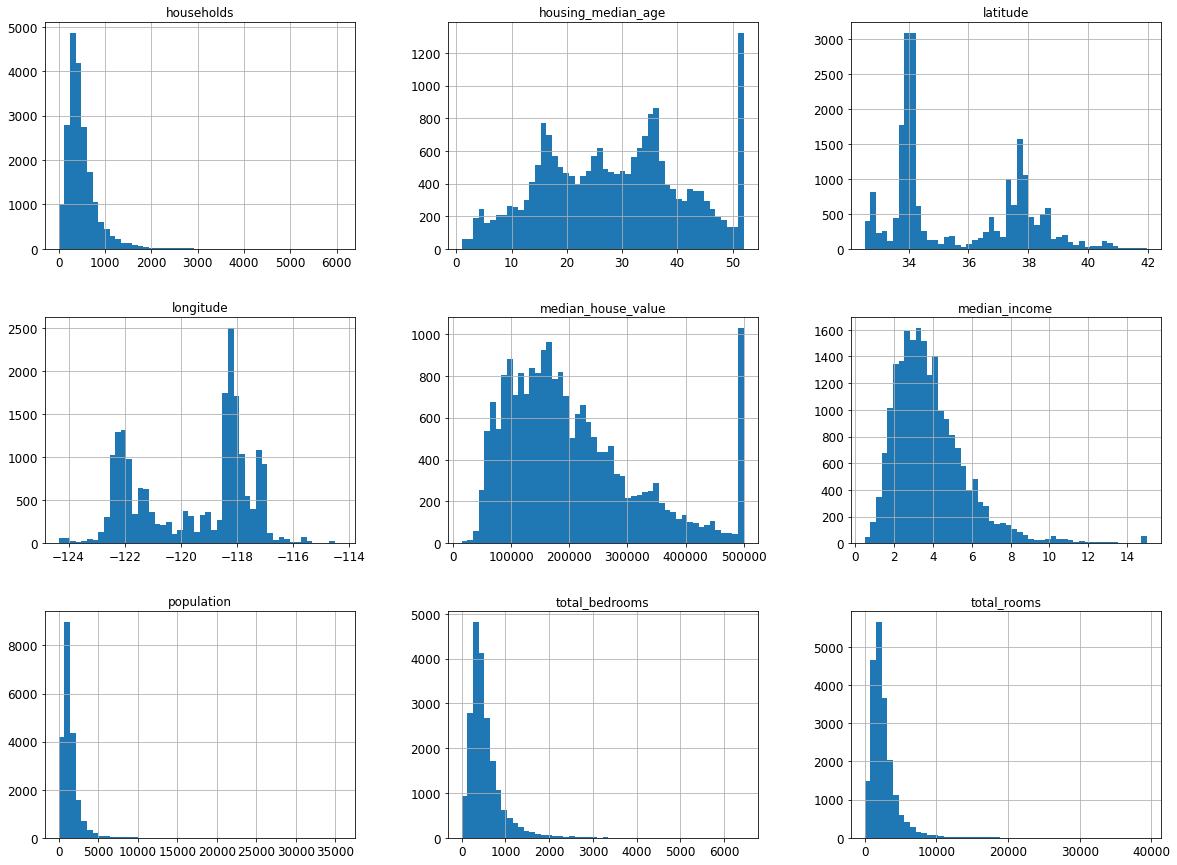

In [8]:
housing.hist(bins=50, figsize=(20,15));

## Create a Test Set

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(housing, test_size=0.2, random_state=42)
train.shape, test.shape

((16512, 10), (4128, 10))

### Stratified split

In [10]:
# Creates an income category attribute 
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [11]:
housing['income_cat'].value_counts().sort_index()

1.0     822
2.0    6581
3.0    7236
4.0    3639
5.0    2362
Name: income_cat, dtype: int64

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [13]:
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [14]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [15]:
# Remove the 'income_cat' attribute so the data is back to its original state
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## Visualizing Geographical Data

In [16]:
# We are only exploring the training set
housing = strat_train_set.copy()

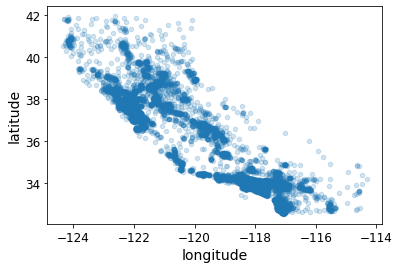

In [17]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2);

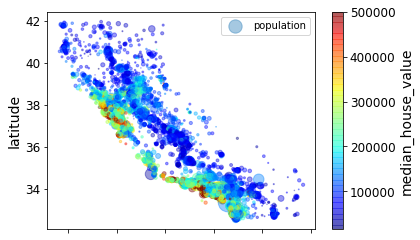

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population',
            c="median_house_value", cmap=plt.get_cmap('jet'),
            colorbar=True)
plt.legend();

In [19]:
# Using California map as background image
import matplotlib.image as mpimg
california_img = mpimg.imread('images/california.png')

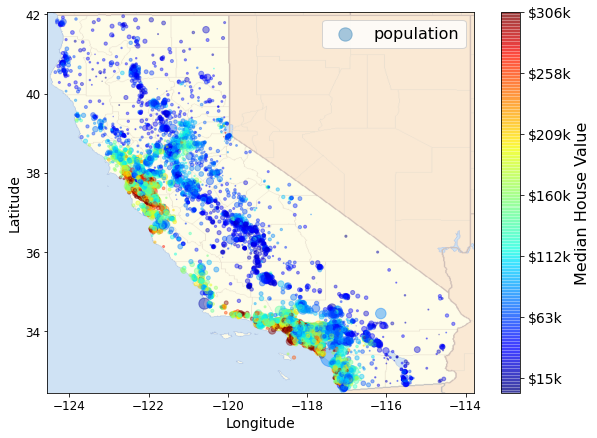

In [20]:
ax = housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population',
            c="median_house_value", cmap=plt.get_cmap('jet'),
            colorbar=False, figsize=(10,7))

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))

plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Longitude', fontsize=14)

prices = housing['median_house_value']
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16);


## Looking for correlations

In [21]:
corr_matrix = housing.corr()

In [22]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [23]:
from pandas.plotting import scatter_matrix

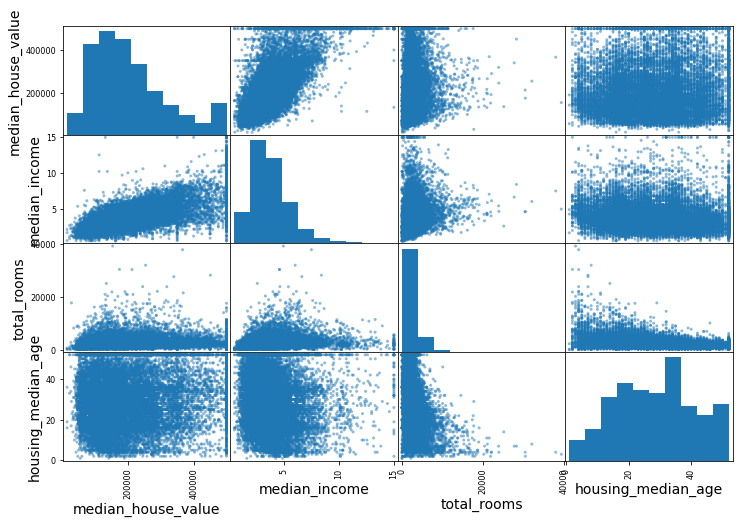

In [24]:
# We select the 4 of 11 more promising attributes
attributes = ['median_house_value', 'median_income', 'total_rooms',
             'housing_median_age']
scatter_matrix(housing[attributes],figsize=(12,8));


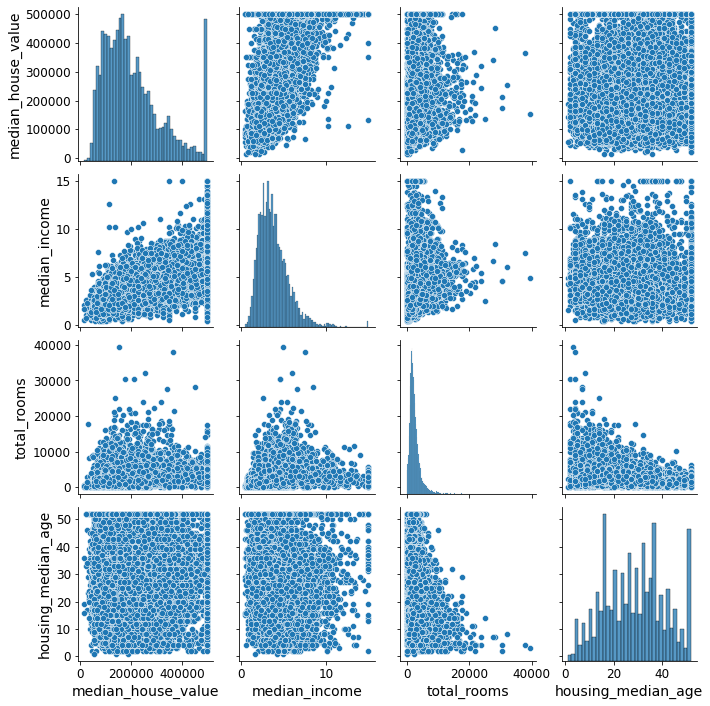

In [25]:
# Seaborn
sns.pairplot(housing[attributes]);

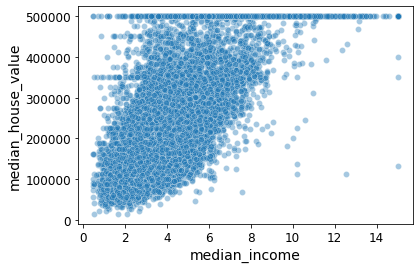

In [26]:
sns.scatterplot(x='median_income', y='median_house_value', data=housing, alpha=0.4);

### New attributes

In [27]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [28]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [29]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare the data for Machine Learning Algorithms

In [30]:
# Let's separate target attribute and predictors since we don't necessarily want
# to apply the same transformations to both of them.
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Data Cleaning

In [31]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [32]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [33]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [34]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [35]:
X = imputer.transform(housing_num)

In [36]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [37]:
housing_tr.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

### Handling Text and Categorical Attributes

In [38]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [39]:
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [40]:
# Let’s encode the categories as one-hot vectors.
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

In [41]:
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [42]:
housing_cat_encoded.reshape(-1,1).shape

(16512, 1)

In [43]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([0, 0, 4, ..., 1, 0, 3])

### Custom transformers

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.transform(housing.values)

Alternatively, you can use Scikit-Learn's FunctionTransformer class that lets you easily create a transformer based on a transformation function (thanks to Hanmin Qin for suggesting this code). Note that we need to set validate=False because the data contains non-float values (validate will default to False in Scikit-Learn 0.22).

In [45]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

### Feature Scaling

In [46]:
# 1. Min-max scaling (normalization) -> MinMaxScaler

# 2. Standarization -> StandardScaler

### Transformation Pipelines

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [48]:
# Pipeline for numerical attributes
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [49]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [50]:
housing_num.shape, housing_num_tr.shape

((16512, 8), (16512, 11))

In [51]:
# Pipeline for both numerical and categorical attributes
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    #('attribs_adder', CombinedAttributesAdder()),
    ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
    ('std_scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

In [52]:
housing_prepared = full_pipeline.fit_transform(housing)

In [53]:
housing.shape

(16512, 9)

In [54]:
housing_prepared.shape

(16512, 16)

## Select and Train a Model

### Training and evaluating on the training set

In [55]:
# Linear Regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [56]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [57]:
# RMSE
from sklearn.metrics import mean_squared_error
housing_prediction = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_prediction)
lin_mse = np.sqrt(lin_mse)
lin_mse

68628.19819848923

In [58]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [59]:
# RSME
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_mse = np.sqrt(tree_mse)
tree_mse

0.0

### Better Evaluation Using Cross-Validation

In [60]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring = 'neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)

In [61]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:",scores.std())

In [62]:
display_scores(rmse_scores)

Scores: [68238.05196774 66817.04578495 70753.16954743 69884.28682243
 70568.69371449 74169.72026563 71656.23162198 70466.17619771
 76555.53603628 69481.84893535]
Mean: 70859.07608940084
Standard Deviation: 2652.359918121003


In [63]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring = 'neg_mean_squared_error', cv=10)
lin_scores = np.sqrt(-lin_scores)

In [64]:
display_scores(lin_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345084
Standard Deviation: 2731.674001798353


In [65]:
%%time
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

CPU times: user 16.9 s, sys: 146 ms, total: 17.1 s
Wall time: 17.1 s


RandomForestRegressor()

In [66]:
%%time
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring = 'neg_mean_squared_error', cv=10)
forest_scores = np.sqrt(-forest_scores)
display_scores(forest_scores)

Scores: [49827.1665571  47458.95317232 49710.01430517 52349.70294588
 49639.53564894 53337.18449877 49026.75948993 48283.41516085
 52722.03925026 50356.71199308]
Mean: 50271.148302229354
Standard Deviation: 1845.3755350102963
CPU times: user 2min 30s, sys: 482 ms, total: 2min 31s
Wall time: 2min 31s


## Fine-Tune Your Model

In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
]

In [68]:
%%time
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                           scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

CPU times: user 51.3 s, sys: 35.8 ms, total: 51.3 s
Wall time: 51.3 s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [69]:
np.sqrt((-grid_search.best_score_))

50092.559626087364

In [70]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [71]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [72]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)


64137.24966232572 {'max_features': 2, 'n_estimators': 3}
55363.32271489049 {'max_features': 2, 'n_estimators': 10}
52526.028303608204 {'max_features': 2, 'n_estimators': 30}
59920.012082685775 {'max_features': 4, 'n_estimators': 3}
53043.18301210728 {'max_features': 4, 'n_estimators': 10}
50845.36212635268 {'max_features': 4, 'n_estimators': 30}
58850.35306731417 {'max_features': 6, 'n_estimators': 3}
52022.03071831019 {'max_features': 6, 'n_estimators': 10}
50092.559626087364 {'max_features': 6, 'n_estimators': 30}
59375.05231779567 {'max_features': 8, 'n_estimators': 3}
52201.78917687376 {'max_features': 8, 'n_estimators': 10}
50165.494210663775 {'max_features': 8, 'n_estimators': 30}
62852.585275858175 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54004.48982089304 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60075.115119613896 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53208.46634917315 {'bootstrap': False, 'max_features': 3, 'n_estimator

### Analyze the Best Models and Their Errors

In [73]:
feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([7.76110940e-02, 7.03154163e-02, 4.29495461e-02, 1.73325598e-02,
       1.74327078e-02, 1.73998106e-02, 1.70843139e-02, 3.23676920e-01,
       6.23695843e-02, 1.06811368e-01, 7.75042043e-02, 7.58732483e-03,
       1.54301254e-01, 9.01933926e-05, 2.83476168e-03, 4.69894150e-03])

In [74]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip( feature_importance, attributes), reverse=True)

[(0.3236769203532205, 'median_income'),
 (0.15430125355309995, 'INLAND'),
 (0.10681136757580728, 'pop_per_hhold'),
 (0.07761109399916744, 'longitude'),
 (0.07750420428373757, 'bedrooms_per_room'),
 (0.07031541634080354, 'latitude'),
 (0.062369584252794125, 'rooms_per_hhold'),
 (0.04294954611597355, 'housing_median_age'),
 (0.01743270780997615, 'total_bedrooms'),
 (0.017399810569401646, 'population'),
 (0.01733255983494878, 'total_rooms'),
 (0.01708431390202471, 'households'),
 (0.0075873248320535245, '<1H OCEAN'),
 (0.004698941499443662, 'NEAR OCEAN'),
 (0.0028347616849778387, 'NEAR BAY'),
 (9.019339256982357e-05, 'ISLAND')]

### Evaluate Your System on the Test set

In [75]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [76]:
final_predictions = final_model.predict(X_test_prepared)

In [77]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48055.806147047995

In [78]:
from scipy import stats

In [79]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                        loc=np.mean(squared_errors),
                        scale=stats.sem(squared_errors)))

array([46008.24792988, 50019.61746463])

In [80]:
# t-score manually
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(46008.24792988391, 50019.61746462701)

In [81]:
# z-score manually
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(46008.861792196854, 50019.05282461689)

## Exercises
### 1.

In [82]:
from sklearn.svm import SVR

In [83]:
param_svm = [
    {'kernel':['linear'], 'C':[10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
    {'kernel':['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
             'gamma':[0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
]

svm_reg = SVR()

In [84]:
%%time
grid_svm = GridSearchCV(svm_reg, 
                        param_svm, 
                        n_jobs=-1, 
                        cv=5, 
                        scoring='neg_mean_squared_error',
                        verbose=2)

#grid_svm.fit(housing_prepared, housing_labels) # best estimator: (kernel='linear', C=30000)
print(grid_svm.best_estimator_)
np.sqrt(-grid_svm.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

### 2.

In [85]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

In [86]:
%%time
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
random_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42, n_jobs=-1)
random_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min


KeyboardInterrupt: 

In [87]:
rmse = np.sqrt(-random_search.best_score_)
rmse

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_score_'

### 3.

In [ ]:
feature_importance

In [ ]:
feature_importance.max()

In [ ]:
np.argpartition(feature_importance, -5)

In [ ]:
np.argpartition(feature_importance, -5)[-5:]

In [ ]:
def top_k(arr, k):
     return np.array(arr).argsort()[-k:][::-1]
    
class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [ ]:
k = 5

In [ ]:
top_k = top_k(feature_importance, k)
top_k

In [ ]:
np.array(attributes)[top_k]

In [ ]:
sorted(zip(feature_importance, attributes), reverse=True)[:k]

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importance, k))
])

In [ ]:
housing_prepared_top_k = preparation_and_feature_selection_pipeline.fit_transform(housing)

### 4.

In [ ]:
preparation_prediction = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeaturesSelector(feature_importance, k)),
    ('svm_reg', SVR(**random_search.best_params_))
])

In [ ]:
prepare_and_predicted = preparation_prediction.fit(housing, housing_labels)

### 5.

In [ ]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

In [ ]:
grid_search_prep.best_params_